# Test the Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import utils
import time
device= torch.device("cuda")

### Neural network class

In [2]:
class rec_neural_net(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers):
        super().__init__()
        
        self.emb_layer = nn.Embedding(vocab_size, embedding_size)
        self.rec_layer = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, bidirectional=True)
        self.lin_layer = nn.Linear(hidden_size*2, output_size)
        
        
    def forward(self, input_seq):
        
        # EMBED THE INPUT SEQUENCE
        # input_seq is a LongTensor of size:   sentence_length x bs
        # input_seq_emb is a Tensor of size:   sentence_length x bs x embedding_size
        input_seq_emb = self.emb_layer( input_seq )
    
        # PROCESS THE SEQUENCE WITH A BIDIRECTIONAL LSTM
        # h_last is (2*num_layers) x bs x hidden_size
        output_seq , (h_last, c_last) = self.rec_layer( input_seq_emb )
        
        # CONCATENATE THE OUTPUT OF THE LSTM FROM EACH DIRECTION
        # h_direc_12 is bs x (2*hidden_size)
        h_direc_1  = h_last[-1,:,:]
        h_direc_2  = h_last[-2,:,:]
        h_direc_12 = torch.cat( (h_direc_1, h_direc_2)  , dim=1) 
        
        # COMPUTE THE SCORES
        scores = self.lin_layer( h_direc_12 )
            
        return scores

### Instanciate the network

In [3]:
vocab_size = 25002
num_layers = 2
emb_size=50
hid_size=50
out_size=2

net=rec_neural_net(vocab_size,emb_size,hid_size, out_size, num_layers)
net = net.to(device)

print(net)
utils.display_num_param(net)

rec_neural_net(
  (emb_layer): Embedding(25002, 50)
  (rec_layer): LSTM(50, 50, num_layers=2, bidirectional=True)
  (lin_layer): Linear(in_features=100, out_features=2, bias=True)
)
There are 1351902 (1.35 million) parameters in this neural network


### Replace the random weights by learned weigths

In [4]:
net.load_state_dict( torch.load( 'trained_parameters_LSTM.pt' ) )

### Putting in Random Reviews from the IMDB Website (With spaces between periods and words).

In [9]:
# Bad Times at the El Royale
#review = "Is it worth wading through 2.5 hours of hyper-violence to arrive at the mildly hopeful suggestion that America's current leadership might unify the country? No. The best thing about Bad Times is Cynthia Erivo's singing. Get the soundtrack, skip the movie."
review ="Every puzzle piece clicks together smoothly, and while there is joy in watching everything fit , the film feels like there's something missing. It lacks true substance. It's all aesthetics , no guts. But damn if the Bad Times aren't beautiful to watch ."
#review = "Bad Times at the El Royale starts with a lot of promise and a full head of steam ; even half-way through I was engaged . But the movie eventually careens off the track ."
#review = "Bad Times at the El Royale isn't an event . But I was never too bored ."
#review = "Just on the performances alone , Bad Times at the El Royale is worth your time and money ."
#review = "The cast are the saving grace of this flamboyant noir carnival that overcooks the cinematography , dialogue , and musical interludes while plot holes and noodly twists present themselves . To put it bluntly , this is 140 minutes of snazzy-looking but forgettable hokum ."

# Goosebumps 2: Haunted Halloween
#review ="It just feels like Sony really wanted to get a sequel out, rushing a lot of elements and making the end product feel disposable."
#review = "This is a kid-friendly monster mash , but it's truly no graveyard smash ." 
#review = "Fails to capture the same energetic spark of the predecessor , but it's an enjoyable family horror film fit for the season nonetheless ."
#review ="Goosebumps 2 is like something you'd see on Nickelodeon around this time of year - glossy, spooky, well-acted, and just about entertaining enough for a lazy Sunday afternoon ."
#review ="Goosebumps 2 is a slapdash sequel to the 2015 hit, picking up with a new group of kids but carrying over the same sense of Halloween fun and mischief as the original ."
#review ="This is not a film that spends time on character development or lessons learned. This is just about the boo-scares and special effects (that spider is pretty cool) , the kind of silliness kids love (a skeleton dog pees on a fire hydrant), and a few self-aware references (Stine sees an “ It ”-style red balloon and sniffs that he thought if it first) . There is that perennial kid favorite: triumph over a bully , plus a reassuring chance to out grown-up the grown-ups and rescue a mom . It’s not as clever or engaging as the first “ Goosebumps , ” and nowhere near Halloween classics like “Monster House , ” “ The Nightmare Before Christmas , ” or “ ParaNorman . ” But striking the right balance of silly and scary makes it trick or treat-worthy , the cinematic equivalent of a fun-size candy bar ."

print(review)

Every puzzle piece clicks together smoothly, and while there is joy in watching everything fit , the film feels like there's something missing. It lacks true substance. It's all aesthetics , no guts. But damn if the Bad Times aren't beautiful to watch .


### Feed this tensor to the net. 

In [11]:
x = utils.text2tensor(review)
bs = 1
x = x.view(-1,1)
scores = net( x.to(device) )

print(scores)

tensor([[-0.5184,  0.5441]], device='cuda:0', grad_fn=<ThAddmmBackward>)


### Put the scores through a softmax then display.

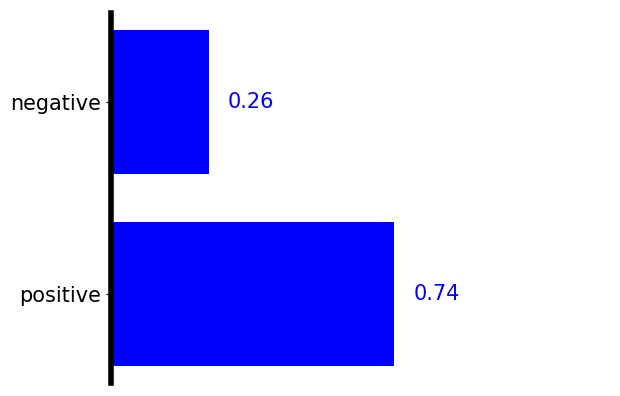

In [12]:
p = F.softmax(scores,dim=1)

utils.show_prob_imdb(p)